# 수량추정

## 5.1 기관차 문제

- 각 철도에 이 위를 지나가는 기관차에 1부터 N까지의 순서로 번호를 붙인다. 하루는 60번 번호가 붙은 기관차를 보았다. 이 때 이 철도에는 몇 개의 기관차가 지나가는지 추정해보자.

관측 결과에 따르면, 이 철도에는 60 개 이상의 기관차가 지나가는 것을 알 수 있다. 하지만 얼마나 더 많을까? 베이지안 추론에 따르면, 이런 문제는 두 단계로 요약할 수 있다.

1. 데이터를 보기 전에 N에 대해 무엇을 알고 있는가?
2. 주어진 모든 N값에 대해서, 관측한 데이터(60호 기관차)의 가능도는 어떻게 되는가?

첫번쨰 질문의 답은 사전확률(prior)이고 두번째 질문의 답은 가능도(likelihood)이다. 
사전확률분포를 확정하기에는 정보가 부족하므로, 간단한 가정으로부터 시작한 다음 이를 수정해 나가자. N은 1부터 1000까지의 값 중 하나가 동일한 확률로 선택될 수 있다고 하자. 

In [67]:
import numpy as np
import pandas as pd
from empiricaldist import Pmf

# 선로를 지나다니는 기차의 개수 N = 1~1000, 이전의 p = 0.1 ~0.4 로 추정하던 것과 동일하다.
hypos = np.arange(1,1001,1)
prior = Pmf(1, hypos) # 각 선택은 동일한 확률분포를 지닌다고 가정(uniform)

In [68]:
def update_train(pmf:Pmf,data)->None:
    hypos = pmf.qs
    # 각 가설하에서 특정 기차가 선택될 확률은 1/N으로 동일하다.
    likelihood = 1/hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

In [69]:
data = 60
posterior = prior.copy()
update_train(posterior, data)

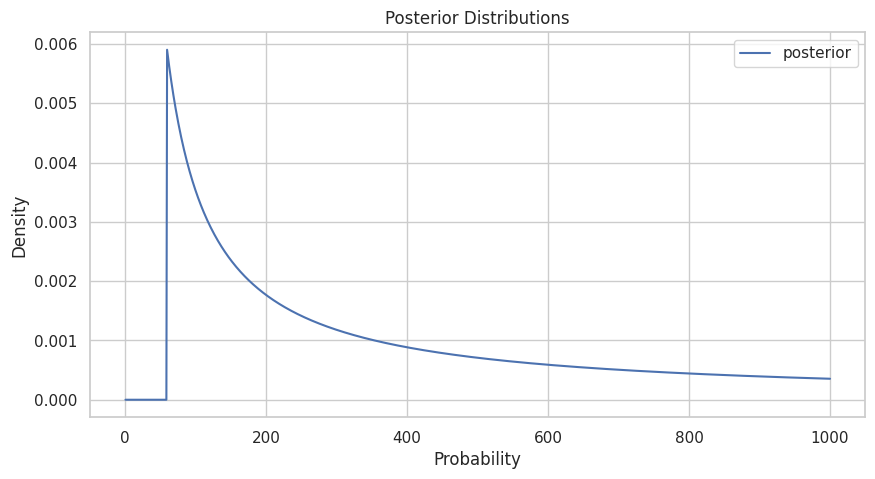

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그림의 가로 세로 비율 조절
plt.figure(figsize=(10, 5))

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 'prior'와 'posterior'를 라벨로 가진 그래프를 생성
posterior.plot(label='posterior')

# title, x label, y label 추가
plt.title('Posterior Distributions')
plt.xlabel('Probability')
plt.ylabel('Density')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

In [71]:
posterior.idxmax()

60

60 이하의 N에 대한 모든 값은 사라졌고, 가장 가능한 값은 예상했던 것처럼 60이다. 

하지만 이는 별로 좋은 추측은 아닌 것 같다. 결국 가장 큰 번호의 기관차를 본 다음에 볼 수 있는 기관차에 대해 어떤 선택지가 있나?

그래서 대안으로 사후확률분포의 평균을 구할 수 있다. 주어진 가능한 수 $q_{i}$와 이에 대한 확률 $p_{i}$에 대해, 분포의 평균값은 다음과 같다.
$$mean = \sum p_{i}q_{i}$$

In [72]:
# 구현

np.sum(posterior.ps * posterior.qs)

333.41989326370776

사후확률분포의 평균은 333이고, 이는 오차를 최소화하고자 할 때 좋은 선택지가 된다. 만약 이런 추측게임을 계속해서 한다면, 사후확률분포의 평균을 추정값으로 사용하는 것이 장기적으로 평균제곱오차를 줄인다.

## 5.2

- 이전 절에서 사용한 사전확률분포는 1부터 1000까지의 균등분포였지만, 균등분포를 선택하거나 특정 상한값을 정하면서 어떤 명시도 하지 않았다. 이런 사전확률분포의 변화에 따라 사후확률분포가 영향을 받을지 궁금할지도 모른다. 
- 아주 적은 데이터, 단 한 개의 관측값에는 그렇다. 상한값을 다양하게 함에 따라 사후확률분포 평균값도 달라진다. 이런 상황은 좋지 않다. 
- 사후확률이 사전확률에 민감하게 반응할 때는 다음과 같은 두 가지 조치를 취할 수 있다. 
  - 데이터를 더 확보하라.
  - 배경지식을 더 확보하고 더 나은 사전확률을 선택하라.
- 데이터를 더 확보하면 서로 다른 사전확률분포 기반으로 만들어진 사후확률분포가 수렴하는 양상을 띈다. 예를 들어, 60번 기관차를 본 후 30번 기관차와 90번 기관차를 봤다고 해보자.
- 차이가 눈에 띄게 줄어든다.

## 5.3

- 만약 데이터를 더 확보할 수 없다면, 다른 옵션으로 배경지식을 더 수집해서 사전확률을 개선하는 방식이 있다. 
- 기관차 운영회사가 1000대의 기관차를 운영한다고 가정하는 것은 철도회사가 세상에 단 하나뿐이라고 생각하는 것만큼 비합리적이다. 
- 철도경영에 관한 특화된 정보를 얻을 수도 있겠지만, 학습된 추측을 할 수도 있다.
- 대부분의 분야에는 여러 작은 회사가 있고, 중견급 회사들은 좀 더 적으며 대기업은 한두 개뿐이다.
- 실제로 회사규모의 분포는 액스텔이 사이언스에 기고한 멱법칙을 따른다. 이 법칙에 따르면 기관차가 10대 미만인 회사가 1,000개일 때 100대의 기관차를 소유한 회사는 100개일 것이고, 1,000대의 기관차를 소유한 회사는 10개, 10,000개의 기관차량을 확보한 회사는 1개다.
- 수학적으로 멱법칙은 주어진 규모 N인 회사의 수는 $(\frac{1}{N})^{\alpha}$에 비례한다는 뜻이다. 이 때 $\alpha$는 1에 가까운 크기의 매개변수다. 
- 멱법칙 사전확률은 다음과 같이 정의된다. 

In [73]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name = 'power law')
print(f'Before normalize:{power}')
power.normalize()
print(f'After normalize:{power}')

Before normalize:1       1.000000
2       0.500000
3       0.333333
4       0.250000
5       0.200000
          ...   
996     0.001004
997     0.001003
998     0.001002
999     0.001001
1000    0.001000
Name: power law, Length: 1000, dtype: float64
After normalize:1       0.133592
2       0.066796
3       0.044531
4       0.033398
5       0.026718
          ...   
996     0.000134
997     0.000134
998     0.000134
999     0.000134
1000    0.000134
Name: power law, Length: 1000, dtype: float64


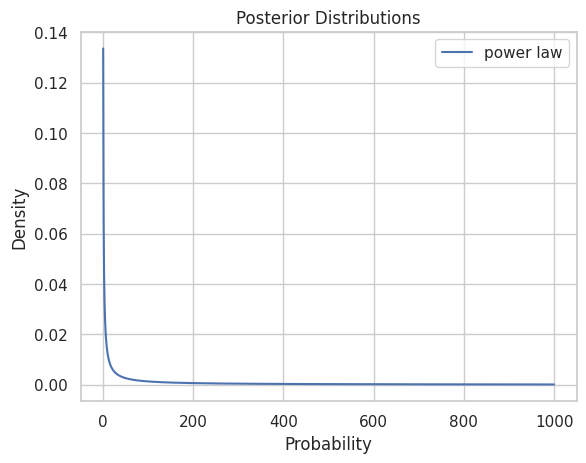

In [74]:
power.plot()
# title, x label, y label 추가
plt.title('Posterior Distributions')
plt.xlabel('Probability')
plt.ylabel('Density')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


이제 확률을 갱신해보자.

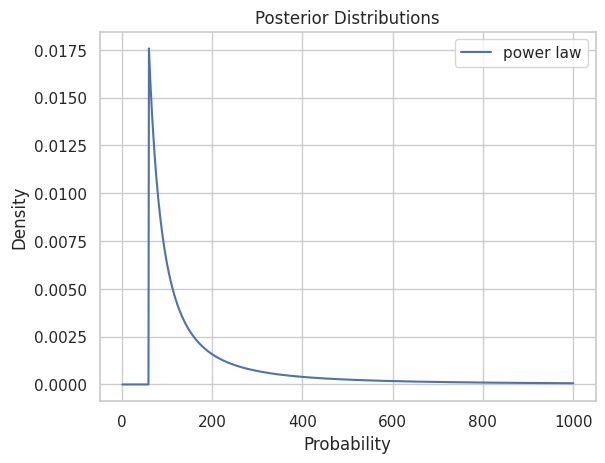

In [75]:
dataset = [60]

update_train(power,data)
power.plot()
# title, x label, y label 추가
plt.title('Posterior Distributions')
plt.xlabel('Probability')
plt.ylabel('Density')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

In [76]:
power.idxmax()

60

## 5.4 신뢰구간

- 앞서 사후확률분포를 최대 사후확률과 사후확률 평균의 두 가지 값을 사용해서 요약했었다. 이는 모두 우리가 관심있어 하는 양을 추정한 값을 단일 숫자로 나타낸 것으로 점추정(point estimate)이라고 한다.
- 사후확률분포를 요약하는 또 다른 방법으로는 백분위값을 사용한다. 표준화 검사를 치러본 적이 있다면 백분위가 익숙하다. 예를 들어, 내 점수가 90분위라고 한다면 이는 내가 이 시험을 치른 사람들의 90%보다 점수가 높거나 같다는 뜻이다. 
- x란 숫자가 있을 때, x와 같거나 더 작은 모든 숫자를 찾아내서 이에 대한 확률을 더해서 백분위 점수(percentile rank)를 구할 수 있다.
- Pmf 는 이 계산을 하는 메소드를 제공한다. 예를 들어 100개 이하의 기관차를 가진 회사의 확률을 구하고 싶다고 한다면 다음과 같이 구할 수 있다.

In [77]:
power.prob_le(100)

0.43374679026783564

- 100개의 기관차는 43분위이다. 다른 방식으로 특정 분위를 구하고 싶다고 해보자. 예를 들어, 확률분포의 중간값은 50분위이다. 
- 우리는 모든 확률을 더해나가면서 0.5를 초과하기 시작할 때를 구할 수 있다. 이를 구하는 함수는 다음과 같다.

In [78]:
def quantile(pmf:Pmf, prob:float)->int:
    """주어진 확률에 대한 분위값을 구함"""
    total = 0 
    for q,p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

In [79]:
quantile(power, 0.5)
# Pmf 는 동일한 기능을 하는 quantile 메서드가 있고, 비슷한 기능으로 주어진 확률을 포함하는 구간을 제공하는 credible_interval()도 제공한다.
# power.qunatile([0.05, 0.95])
# power.credible_interval(0.90)

112

## 5.5 독일탱크 문제

- 서방 연합국에서는 각 탱크의 샤시와 엔진의 시리얼 번호를 포함한 기록 책자와 장부 및 수리기록을 확보했다.
- 이 기록을 분석해보니, 시리얼 번호는 제조사에 따라 할당되어 있고 탱크 유형은 100개의 숫자블록으로 이루어져 있었다.
- 각 블록의 숫자는 순차적으로 사용되었으나 모든 숫자를 사용하고 있는 것은 아니었다. 따라서 독일 탱크 생산량을 추정하는 문제는 100개의 숫자 블록 각각에 대해 기관차 문제 형태로 단순화할 수 있다.
- 이런 이해를 바탕으로, 미국과 영국 분석가들은 다른 정보를 취합한 후 경제적 정보를 도출했다.


## 5.6 정보성 사전확률

- 베이지안이 사전확률분포를 선택하는 방법은 두 가지가 있다. 혹자는 문제의 배경 지식을 가장 잘 표현하는 사전확률을 선택하는 것을 추천한다. 이런 경우 사전확률분포는 __정보성(informative)__ 이라고 한다.
- 정보성 사전확률분포를 사용하는 경우 사람들이 서로 다른 배경지식을 가지고 있거나 동일한 정보도 서로 다르게 해석한다는 문제점이 있다. 따라서 정보성 사전확률은 때떄로 주관적이다.
- 다른 방법으로는 __비정보성 사전확률(uninformative prior)__ 이 있다. 이는 데이터가 최대한 직접 말할 수 있도록 최대한 제약을 제거한다. 어떤 경우에는 추정량에 대한 최소한의 사전 정보를 제공하는 등으 ㅣ몇 가지 필요한 특성을 나타내는 고유의 사전확률을 정의할 수도 있다.
- 비정보성 사전확률은 객관적이라는 점에서 매력이 있지만, 필자는 일반적으로 정보성 사전확률을 선호한다. 왜일까?
- 첫째로 베이지안 분석은 항상 모델 결정에 근거한다. 사전확률을 선택하는 것 역시 이런 모델 결정 중에 하나이지만, 유일하지는 않으며, 심지어는 가장 주관적인 결정이 될 수도 있다. 따라서 비정보성 사전확률이 더 객관적이라 하더라도, 전체 분석은 여전히 주관적이게 된다.
- 또 가장 실전적인 문제로, 보통 데이터가 굉장히 많거나 굉장히 없는 두 가지 상황 중 하나에 속해있을 때가 많다. 만약 데이터가 굉장히 많은 경우라면, 사전확률분포를 무엇으로 고르든지 상관없다. 
- 사전확률분포를 무엇으로 고르든 거의 유사한 결과를 도출한다. 
- 반대로 데이터가 별로 없다면, 관련 배경 지식(멱법칙 분포 등)을 사용하면 큰 차이가 난다.
- 그리고 만약 독일 탱크 문제처럼 결과에 따라 사람의 생사를 결정하게 된다면, 본인이 알고 있는 것보다 적게 알고 있는 척하는 객관성의 환상에 젖어있는 대신 본인이 알고 있는 모든 정보를 써야 한다.

## 5.7 요약

- 이 장에서는 기관차의 문제를 다뤘는데, 결국 이 모든 예제는 모수의 크기나 개수를 추정하는 것이다.

## 5.8 연습 문제

### 문제 5-1

- 큰 강의실에서 발표를 하던 도중, 소방 책임자가 중간에 들어 와서 청중 수가 방의 안전제한 인원이 1,200명을 넘는 것 같다고 했다. 
- 하지만 당신이 생각하기에 청중이 1,200명보다는 적을 것 같아서 이를 증명해 보이기로 했다. 사람 수를 하나하나 세려면 너무 오래 걸리므로, 다음과 같이 실험을 해보기로 했다.
  - 이 방에서 5월 11일에 태어난 사람을 물었더니 두 사람이 손을 들었다.
  - 5월 23일에 태어난 사람을 물었을 때 한 사람이 손을 들었다.
  - 마지막으로, 8월 1일에 태어난 사람을 묻자 아무도 손을 들지 않았다.
- 이 경우, 청중은 몇 명이나 될까? 이 방의 인원이 1,200명을 넘을 확률은 얼마인가?
- HINT: 이항분포를 기억하자.

In [82]:
from scipy.stats import binom

hypos = np.arange(1,2000,10)
prior = Pmf(1,hypos)
prior.normalize()

def update_student(pmf:Pmf, k):
    likelihood = binom.pmf(k,hypos,1/365)
    pmf *= likelihood
    pmf.normalize()

posterior = prior.copy()
update_student(posterior, 2)
update_student(posterior, 1)
update_student(posterior, 0)

In [85]:
posterior.quantile(0.99)

array(1221.)

In [84]:
posterior.prob_gt(1200)

0.011543092507705213

### 문제 5-2

- 나는 종종 집 뒷마당에서 토끼를 보지만, 잘 분간하지 못하기 때문에 몇 마리인지는 잘 모른다. 내가 모션 카메라를 통해 매일 처음 보는 토끼의 사진을 찍었다고 해보자. 3일이 지난 후, 사진을 비교해 봤더니 두 장은 같은 토끼였고 한 장은 다른 토끼였다.
- 뒷마당엔 토끼가 몇 마리 있을까?
- 이 질문에 답하기 위해, 사전확률분포와 데이터의 우도에 대해 고민해 볼 필요가 있다.
  - 가끔 토끼 4마리를 동시에 본 적도 있으므로, 최소한 이 정도라는 것을 안다. 만약 10마리 이상이 있다면 신기할 것이다. 따라서 시작으로는 4부터 10까지의 균등사전분포가 적절하다.
  - 간단히 하기 위해, 마당에 들어오는 토끼는 주어진 날에 카메라 트랩에 잡힐 확률이 동일하다고 가정하자. 그리고 카메라 트랩이 매일 사진을 찍는다고 하자.

In [87]:
hypos = np.arange(4,11,1)
prior = Pmf(1,hypos)
prior.normalize()
prior

,probs
4,1
5,1
6,1
7,1
8,1
9,1
10,1


In [88]:
posterior = prior.copy()
N = hypos
# 첫번쨰 토끼가 두번째 토끼와 동일할 확률. 첫번쨰 토끼가 두번쨰 날에도 똑같이 발견될 확률과 동일함 1/N
# 세번쨰 날 발견될 토끼가 이전과 다를 확률 (N-1)/N
likelihood = (N-1) / N **2
posterior *= likelihood
posterior.normalize()

0.906978300579491

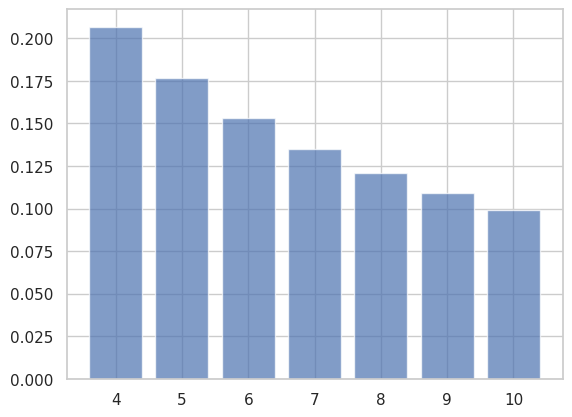

In [89]:
posterior.bar(alpha = 0.7)
plt.xlabel='Number of rabbits'
plt.ylabel='PMF'
plt.title='The Rabbit Problem'
plt.show()

In [90]:
posterior.mean()

6.509929813748172

### 문제 5-3

- 범죄구형 시스템에서 모든 징역형은 1,2,3 년 중 하나고 각각 동일한 숫자의 인원이 구형된다. 어느 날, 감옥을 방문해서 임의로 한 명의 죄수를 만났다. 
- 이 죄수가 3년형을 받았을 확률은 얼마인가? 관찰한 죄수의 남은 형량의 평균은 얼마일까?

In [92]:
hypos = np.arange(1,4)
prior = Pmf(1/3, hypos)
prior

,probs
1,0.333333
2,0.333333
3,0.333333


In [93]:
likelihood = hypos # 1,2,3 
posterior = prior * likelihood # the probability of observing any given prisoner is proportional to the duration of their sentence.
posterior.normalize()
posterior

,probs
1,0.166667
2,0.333333
3,0.500000


In [94]:
posterior.mean()

2.333333333333333

### 문제 5.4

- 만약 미국에서 한 명의 성인을 임의로 골랐을 때, 그 사람이 형제나 자매가 있을 확률은 얼마인가? 
- 보다 정확하게, 그 사람의 어머니가 그 사람 외에 한 명 이상의 자녀를 두었을 확률은 얼마인가?

### 문제 5.5 

- 인류 종말 논법은 현재까지 태어난 인류 수의 추측을 통해 미래에 태어날 모든 인류의 수를 예측하는 통계학적인 논법이다.
- 우주에는 단 두 종류의 지적문명이 존재한다고 가정하자. 짧게 산 종은 2천억 개체만 태어난 후 멸종한다. 오래 산 종은 2조의 개체가 태어날 때까지 생존한다.
- 두 종류의 문명이 일어날 가능성은 동일하다.
- 우리가 어느 쪽의 문명에 사는 것이 좋을까?
- 미국 인구조회국에 따르면, 지금까지 살아있던 사람은 총 1,080억 명이다. 
- 당신이 최근 태어났다면, 대략 당신의 인류번호는 1,080억 번이다. 만약 지금까지 살았던 사람의 수가 N이고 당신이 이 중 임의로 선택되었다면, 당신이 1번이든 N번이든 혹은 이 사이의 어떤 인류 번호를 가지든 확률은 동일하다. 
- 이 때 인류번호가 1,080억일 확률은 얼마일까?
- 이 데이터와 불확실한 사전확률을 사용했을 때, 우리 문명이 짧게 산 종류일 확률은 얼마일까?

In [95]:
hypos = [200, 2000]
prior = Pmf(1, hypos)
likelihood = 1/prior.qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
200,0.909091
2000,0.090909
